In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

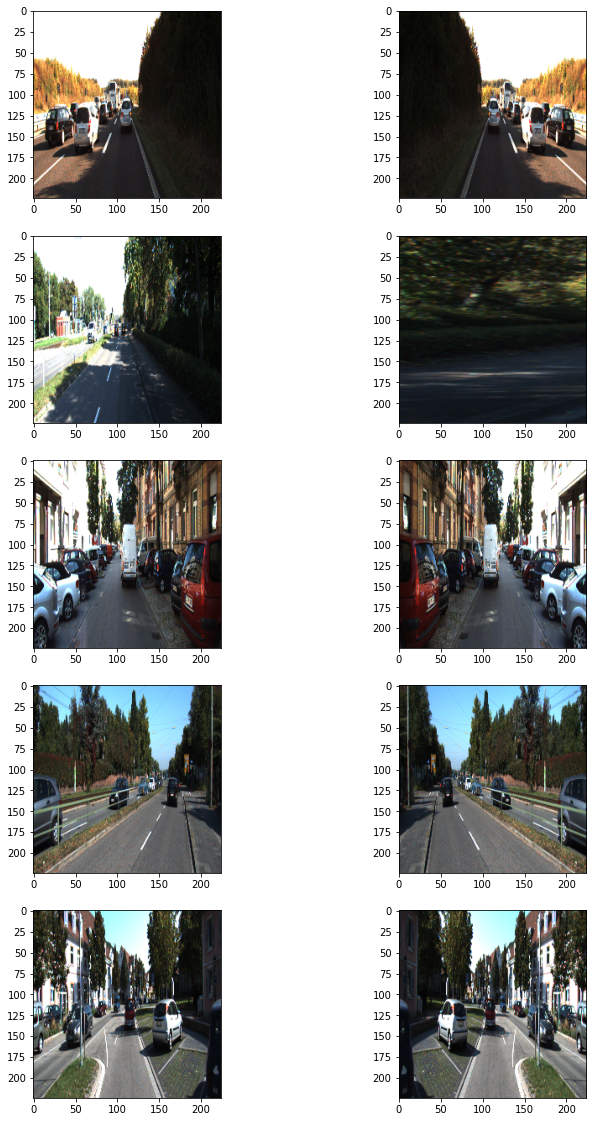

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [3]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [4]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

def build_model(input_shape=(224, 224, 3)):
    # 입력 레이어
    inputs = Input(shape=input_shape)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Expanding Path
    up4 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    merge4 = concatenate([conv2, up4])
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv4)
    merge5 = concatenate([conv1, up5])
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # 출력 레이어
    outputs = Conv2D(1, 1, activation='sigmoid')(conv5) # 이 예시에서는 이진 분류를 위해 sigmoid 사용

    # 모델 생성
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [6]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)

Epoch 1/100
11/11 [==============================] - 16s 401ms/step - loss: 0.6888 - val_loss: 0.6808
Epoch 2/100
11/11 [==============================] - 4s 378ms/step - loss: 0.6613 - val_loss: 0.6165
Epoch 3/100
11/11 [==============================] - 4s 377ms/step - loss: 0.4662 - val_loss: 0.2271
Epoch 4/100
11/11 [==============================] - 4s 382ms/step - loss: 0.1726 - val_loss: 0.0674
Epoch 5/100
11/11 [==============================] - 4s 385ms/step - loss: 0.0369 - val_loss: 0.0374
Epoch 6/100
11/11 [==============================] - 4s 390ms/step - loss: 0.0328 - val_loss: 0.0333
Epoch 7/100
11/11 [==============================] - 4s 396ms/step - loss: 0.0273 - val_loss: 0.0347
Epoch 8/100
11/11 [==============================] - 4s 400ms/step - loss: 0.0315 - val_loss: 0.0322
Epoch 9/100
11/11 [==============================] - 4s 399ms/step - loss: 0.0311 - val_loss: 0.0320
Epoch 10/100
11/11 [==============================] - 4s 399ms/step - loss: 0.0224 - val_l

11/11 [==============================] - 4s 394ms/step - loss: 0.0096 - val_loss: 0.0176
Epoch 82/100
11/11 [==============================] - 4s 395ms/step - loss: 0.0085 - val_loss: 0.0291
Epoch 83/100
11/11 [==============================] - 4s 395ms/step - loss: 0.0141 - val_loss: 0.0211
Epoch 84/100
11/11 [==============================] - 4s 396ms/step - loss: 0.0142 - val_loss: 0.0138
Epoch 85/100
11/11 [==============================] - 4s 400ms/step - loss: 0.0136 - val_loss: 0.0237
Epoch 86/100
11/11 [==============================] - 4s 394ms/step - loss: 0.0144 - val_loss: 0.0137
Epoch 87/100
11/11 [==============================] - 4s 396ms/step - loss: 0.0107 - val_loss: 0.0151
Epoch 88/100
11/11 [==============================] - 4s 398ms/step - loss: 0.0130 - val_loss: 0.0217
Epoch 89/100
11/11 [==============================] - 4s 396ms/step - loss: 0.0109 - val_loss: 0.0151
Epoch 90/100
11/11 [==============================] - 4s 395ms/step - loss: 0.0123 - val_loss: 

In [13]:
def conv_block(inputs, filters, kernel_size=3):
    x = Conv2D(filters, kernel_size, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    return x

def plus_build_model(input_shape=(224, 224, 3)):
    # 입력 레이어
    inputs = Input(input_shape)

    # 첫 번째 Contracting Path
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # 두 번째 Contracting Path
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # 세 번째 Contracting Path
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # 네 번째 Contracting Path
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Expanding Path
    up4 = UpSampling2D(size=(2, 2))(pool4)
    up4 = Conv2D(256, 2, activation='relu', padding='same')(up4)
    merge4 = concatenate([conv4, up4], axis=3)
    conv5 = conv_block(merge4, 512)

    up3 = UpSampling2D(size=(2, 2))(conv5)
    up3 = Conv2D(128, 2, activation='relu', padding='same')(up3)
    merge3 = concatenate([conv3, up3], axis=3)
    conv6 = conv_block(merge3, 256)

    up2 = UpSampling2D(size=(2, 2))(conv6)
    up2 = Conv2D(64, 2, activation='relu', padding='same')(up2)
    merge2 = concatenate([conv2, up2], axis=3)
    conv7 = conv_block(merge2, 128)

    up1 = UpSampling2D(size=(2, 2))(conv7)
    up1 = Conv2D(32, 2, activation='relu', padding='same')(up1)
    merge1 = concatenate([conv1, up1], axis=3)
    conv8 = conv_block(merge1, 64)

    # 출력 레이어
    output = Conv2D(1, 1, activation='sigmoid')(conv8)

    # 모델 생성
    model = Model(inputs=inputs, outputs=output)

    return model

In [14]:
plus_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet++.h5'

plus_model = plus_build_model()
plus_model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
plus_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
     batch_size=32
 )

plus_model.save(plus_model_path)

Epoch 1/100
11/11 [==============================] - 22s 815ms/step - loss: 0.7503 - val_loss: 0.6796
Epoch 2/100
11/11 [==============================] - 8s 755ms/step - loss: 0.7057 - val_loss: 0.6678
Epoch 3/100
11/11 [==============================] - 8s 733ms/step - loss: 0.6758 - val_loss: 0.6595
Epoch 4/100
11/11 [==============================] - 8s 719ms/step - loss: 0.6638 - val_loss: 0.6551
Epoch 5/100
11/11 [==============================] - 8s 712ms/step - loss: 0.6587 - val_loss: 0.6457
Epoch 6/100
11/11 [==============================] - 8s 712ms/step - loss: 0.6315 - val_loss: 0.6421
Epoch 7/100
11/11 [==============================] - 8s 711ms/step - loss: 0.6161 - val_loss: 0.6335
Epoch 8/100
11/11 [==============================] - 8s 716ms/step - loss: 0.5864 - val_loss: 0.5957
Epoch 9/100
11/11 [==============================] - 8s 725ms/step - loss: 0.5858 - val_loss: 0.5700
Epoch 10/100
11/11 [==============================] - 8s 732ms/step - loss: 0.5471 - val_l

11/11 [==============================] - 8s 725ms/step - loss: 0.1646 - val_loss: 0.1171
Epoch 82/100
11/11 [==============================] - 8s 723ms/step - loss: 0.1474 - val_loss: 0.0766
Epoch 83/100
11/11 [==============================] - 8s 723ms/step - loss: 0.1304 - val_loss: 0.0870
Epoch 84/100
11/11 [==============================] - 8s 723ms/step - loss: 0.1178 - val_loss: 0.0847
Epoch 85/100
11/11 [==============================] - 8s 724ms/step - loss: 0.1314 - val_loss: 0.3485
Epoch 86/100
11/11 [==============================] - 8s 723ms/step - loss: 0.1602 - val_loss: 1.1129
Epoch 87/100
11/11 [==============================] - 8s 723ms/step - loss: 0.1500 - val_loss: 2.0170
Epoch 88/100
11/11 [==============================] - 8s 723ms/step - loss: 0.1523 - val_loss: 1.3519
Epoch 89/100
11/11 [==============================] - 8s 723ms/step - loss: 0.1284 - val_loss: 2.1605
Epoch 90/100
11/11 [==============================] - 8s 725ms/step - loss: 0.1060 - val_loss: 

In [15]:
#U-net vs U-net ++
unet_plus_model = tf.keras.models.load_model(plus_model_path)
unet_model = tf.keras.models.load_model(model_path)

In [16]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

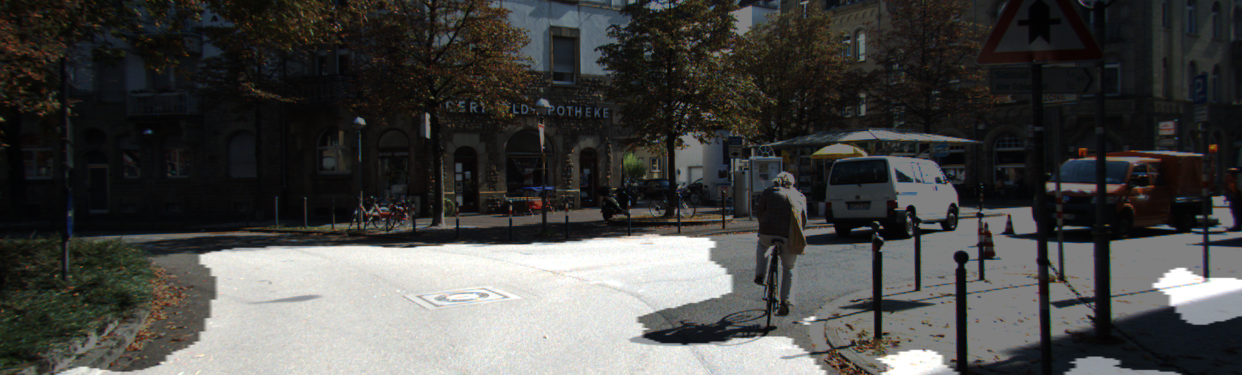

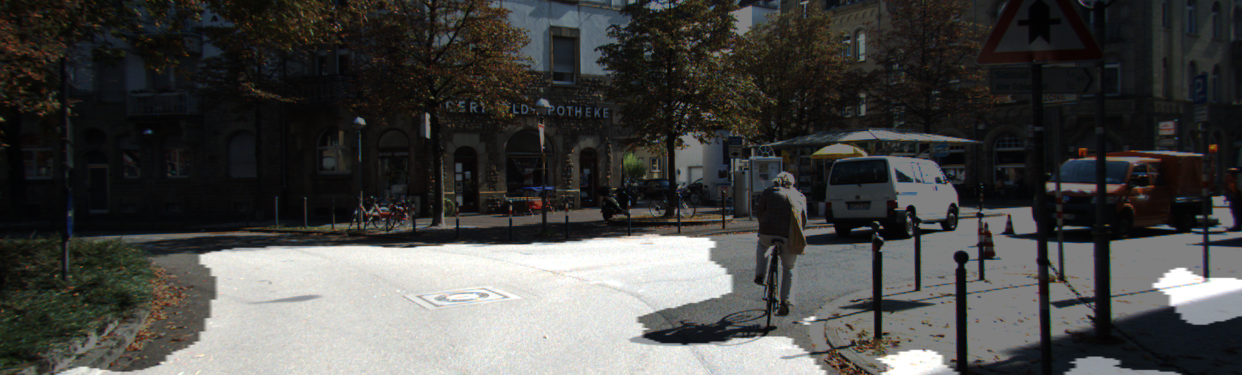

In [19]:
i = 3    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [21]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction).sum()
    union = np.logical_or(target, prediction).sum()
    iou_score = float(intersection) / union
    print('IoU: %f' % iou_score)
    return iou_score

def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  # threshold를 변경하면 도로인식 범위 달라짐
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

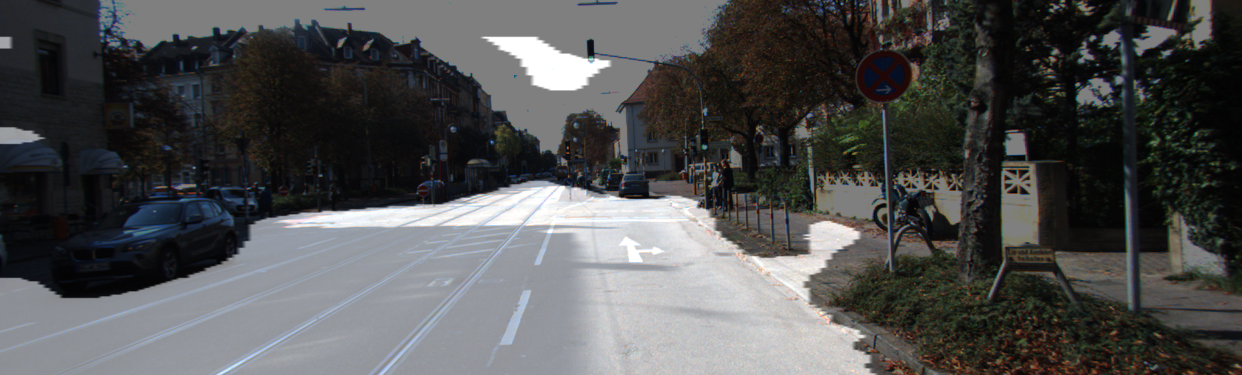

IoU: 0.892937


0.8929373415429193

In [22]:
# 시각화한 결과를 눈으로 확인
i = 1 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

In [ ]:
unet_iou = []
unet_plus_iou = []

for i in range(1, 50):
    output, prediction, target = get_output(
     unet_model,
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png')
    
    unet_iou.append(calculate_iou_score(target, prediction))
    
    output, prediction, target = get_output(
     unet_plus_model,
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png')
    
    unet_plus_iou.append(calculate_iou_score(target, prediction))

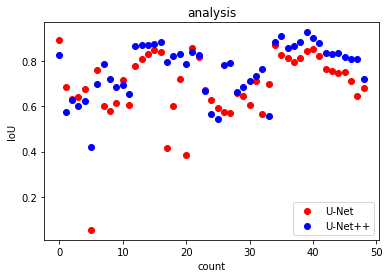

In [24]:
plt.scatter(range(len(unet_iou)), unet_iou, c="r", label="U-Net")
plt.scatter(range(len(unet_plus_iou)), unet_plus_iou, c="b", label="U-Net++")
plt.title("analysis")
plt.legend()
plt.ylabel("IoU")
plt.xlabel("count")
plt.show()

In [ ]:
# 후기
50개의 샘플정도면 나름 유의미한 결과가 나왔을거라 기대한다.
U-Net++가 일반 U-Net보다 튀는 값도 더 적고 평균적으로 높게 iou가 잡히지만 엄청난 차이는 보이지 않는다.
아마 U-Net3+ 쯤 가면 눈에 더 띄게 차이가 날것 같다.
그리고 파이토치로 정규화와 albumentation을 더 쉽게 하던데 나중에 똑같은 프로젝트를 파이토치로 한번 더 구현해보려는 계획이 있다.
아직은 케라스도 벅차지만 나중에 pytorch로 꼭 갈아 탈것이다.